In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/awwwwwwwww/valid/labels/4 (162).txt
/kaggle/input/awwwwwwwww/valid/labels/1 (5).txt
/kaggle/input/awwwwwwwww/valid/labels/4 (43).txt
/kaggle/input/awwwwwwwww/valid/labels/4 (197).txt
/kaggle/input/awwwwwwwww/valid/labels/1 (127).txt
/kaggle/input/awwwwwwwww/valid/labels/3 (376).txt
/kaggle/input/awwwwwwwww/valid/labels/3 (154).txt
/kaggle/input/awwwwwwwww/valid/labels/1 (369).txt
/kaggle/input/awwwwwwwww/valid/labels/4 (74).txt
/kaggle/input/awwwwwwwww/valid/labels/4 (278).txt
/kaggle/input/awwwwwwwww/valid/labels/1 (145).txt
/kaggle/input/awwwwwwwww/valid/labels/3 (11).txt
/kaggle/input/awwwwwwwww/valid/labels/1 (212).txt
/kaggle/input/awwwwwwwww/valid/labels/1 (249).txt
/kaggle/input/awwwwwwwww/valid/labels/4 (135).txt
/kaggle/input/awwwwwwwww/valid/labels/1 (284).txt
/kaggle/input/awwwwwwwww/valid/labels/4 (186).txt
/kaggle/input/awwwwwwwww/valid/labels/4 (283).txt
/kaggle/input/awwwwwwwww/valid/labels/2 (17).txt
/kaggle/input/awwwwwwwww/valid/labels/1 (291).txt
/kaggl

In [2]:
import torch


BATCH_SIZE = 8
RESIZE_TO = 640
NUM_EPOCHS = 60
NUM_WORKERS = 4

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

TRAIN_DIR = "/kaggle/input/awwwwwwwww/train"
VALID_DIR = "/kaggle/input/awwwwwwwww/valid"

CLASSES = ["__background__", "buffalo", "elephant", "rhino", "zebra"]


NUM_CLASSES = len(CLASSES)

# Whether to visualize images after crearing the data loaders.
VISUALIZE_TRANSFORMED_IMAGES = True

OUT_DIR = "/kaggle/working"

In [3]:
import torchvision
import torch

from functools import partial
from torchvision.models.detection import RetinaNet_ResNet50_FPN_V2_Weights
from torchvision.models.detection.retinanet import RetinaNetClassificationHead

def create_model(num_classes=5):
    """
    Creates a RetinaNet-ResNet50-FPN v2 model pre-trained on COCO.
    Replaces the classification head for the required number of classes.
    """
    model = torchvision.models.detection.retinanet_resnet50_fpn_v2(weights=RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1)
    num_anchors = model.head.classification_head.num_anchors

    model.head.classification_head = RetinaNetClassificationHead(
        in_channels=256, num_anchors=num_anchors, num_classes=num_classes, norm_layer=partial(torch.nn.GroupNorm, 32)
    )
    return model

In [4]:
import albumentations as A
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


from albumentations.pytorch import ToTensorV2
plt.style.use("ggplot")


class Averager:
    """
    A class to keep track of running average of values (e.g. training loss).
    """

    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


class SaveBestModel:
    """
    Saves the model if the current epoch's validation mAP is higher
    than all previously observed values.
    """

    def __init__(self, best_valid_map=float(0)):
        self.best_valid_map = best_valid_map

    def __call__(
        self,
        model,
        current_valid_map,
        epoch,
        OUT_DIR,
    ):
        if current_valid_map > self.best_valid_map:
            self.best_valid_map = current_valid_map
            print(f"\nBEST VALIDATION mAP: {self.best_valid_map}")
            print(f"SAVING BEST MODEL FOR EPOCH: {epoch+1}\n")
            torch.save(
                {
                    "epoch": epoch + 1,
                    "model_state_dict": model.state_dict(),
                },
                f"{OUT_DIR}/best_model.pth",
            )


def collate_fn(batch):
    """
    To handle the data loading as different images may have different
    numbers of objects, and to handle varying-size tensors as well.
    """
    imgs, targets = zip(*batch)
    return list(imgs), list(targets)
    #return tuple(zip(*batch))


def get_train_transform():
    # We keep "pascal_voc" because bounding box format is [x_min, y_min, x_max, y_max].
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=45),
            A.Blur(blur_limit=3, p=0.2),
            A.MotionBlur(blur_limit=3, p=0.1),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.3),
            A.RandomScale(scale_limit=0.2, p=0.3),
            ToTensorV2(p=1.0),
        ],
        bbox_params={"format": "pascal_voc", "label_fields": ["labels"]},
    )

def get_train_transform():
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),            # ← image & boxes both flipped 50% of the time
            A.RandomBrightnessContrast(p=0.2),  # ← photometric change (boxes unaffected)
            ToTensorV2(),                       # ← final tensor conversion
        ],
        bbox_params=A.BboxParams(
            format="pascal_voc",
            label_fields=["labels"]
        ),
    )

def get_valid_transform():
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),            # ← image & boxes both flipped 50% of the time
            A.RandomBrightnessContrast(p=0.2),  # ← photometric change (boxes unaffected)
            ToTensorV2(),                       # ← final tensor conversion
        ],
        bbox_params=A.BboxParams(
            format="pascal_voc",
            label_fields=["labels"]
        ),
    )

def show_tranformed_image(train_loader):
    """
    Visualize transformed images from the `train_loader` for debugging.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """
    if len(train_loader) > 0:
        for i in range(2):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)

            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            for i in range(len(images)):
                if len(targets[i]["boxes"]) == 0:
                    continue
                boxes = targets[i]["boxes"].cpu().numpy().astype(np.int32)
                labels = targets[i]["labels"].cpu().numpy().astype(np.int32)
                sample = images[i].permute(1, 2, 0).cpu().numpy()
                sample = cv2.cvtColor(sample, cv2.COLOR_RGB2BGR)

                for box_num, box in enumerate(boxes):
                    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)
                    cv2.putText(
                        sample,
                        CLASSES[labels[box_num]],
                        (box[0], box[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1.0,
                        (0, 0, 255),
                        2,
                    )
                cv2_imshow(sample)


def save_model(epoch, model, optimizer):
    """
    Save the trained model (state dict) and optimizer state to disk.
    """
    torch.save(
        {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        "outputs/last_model.pth",
    )


def save_loss_plot(OUT_DIR, train_loss_list, x_label="iterations", y_label="train loss", save_name="train_loss"):
    """
    Saves the training loss curve.
    """
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss_list, color="tab:blue")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.savefig(f"{OUT_DIR}/{save_name}.png")
    # plt.close()
    print("SAVING PLOTS COMPLETE...")


def save_mAP(OUT_DIR, map_05, map):
    """
    Saves the mAP@0.5 and mAP@0.5:0.95 curves per epoch.
    """
    plt.figure(figsize=(10, 7))
    plt.plot(map_05, color="tab:orange", linestyle="-", label="mAP@0.5")
    plt.plot(map, color="tab:red", linestyle="-", label="mAP@0.5:0.95")
    plt.xlabel("Epochs")
    plt.ylabel("mAP")
    plt.legend()
    plt.savefig(f"{OUT_DIR}/map.png")
    # plt.close()
    print("SAVING mAP PLOTS COMPLETE...")

In [5]:
import os
import glob

import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import box_convert
from torchvision.transforms import Normalize

# ImageNet normalization constants for pretrained backbones
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]


In [6]:
# ─────────────────────────────────────────────────────────────────────────────
# 1) BOOTSTRAP YOUR SPLITS (write to working dir, not /kaggle/input)
# ─────────────────────────────────────────────────────────────────────────────
import os, random

IMAGES_DIR = "/kaggle/input/awwwwwwwww/train/images"
LABELS_DIR = "/kaggle/input/awwwwwwwww/train/labels"
SPLIT_DIR  = "."            # working directory
LABELED_FILE   = os.path.join(SPLIT_DIR, "labeled.txt")
UNLABELED_FILE = os.path.join(SPLIT_DIR, "unlabeled.txt")

# collect all images that actually have a label file
all_imgs = []
for fn in sorted(os.listdir(IMAGES_DIR)):
    if fn.lower().endswith((".jpg",".jpeg",".png",".ppm")):
        lbl = os.path.splitext(fn)[0] + ".txt"
        if os.path.exists(os.path.join(LABELS_DIR, lbl)):
            all_imgs.append(fn)

# if splits don't exist locally, create them
if not os.path.exists(LABELED_FILE) or not os.path.exists(UNLABELED_FILE):
    seed_frac = 0.1
    k = max(1, int(seed_frac * len(all_imgs)))
    seed = random.sample(all_imgs, k)
    pool = [f for f in all_imgs if f not in seed]
    with open(LABELED_FILE,   "w") as f: f.write("\n".join(seed))
    with open(UNLABELED_FILE, "w") as f: f.write("\n".join(pool))
    print(f"Bootstrapped: {len(seed)} labeled, {len(pool)} unlabeled")
else:
    print("Found existing splits.")

# utility to read them
def read_list(path):
    with open(path) as f:
        return [l.strip() for l in f if l.strip()]

labeled_list   = read_list(LABELED_FILE)
unlabeled_list = read_list(UNLABELED_FILE)
print(f"→ {len(labeled_list)} labeled, {len(unlabeled_list)} unlabeled images")


Bootstrapped: 105 labeled, 947 unlabeled
→ 105 labeled, 947 unlabeled images


In [7]:
# ─────────────────────────────────────────────────────────────────────────────
# 2) ActiveLearningDataset reads splits from working dir (never writes under /kaggle/input)
# ─────────────────────────────────────────────────────────────────────────────
import glob

import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Normalize

class ActiveLearningDataset(Dataset):
    def __init__(self,
                 root_dir: str,
                 classes: list[str],
                 transforms=None,
                 img_size: int = 640,
                 split: str = "all",
                 split_dir: str = "."):
        """
        root_dir: contains images/ and labels/ (read-only)
        split_dir: working directory where labeled.txt & unlabeled.txt live
        split: 'seed', 'pool', or 'all'
        """
        self.image_dir  = os.path.join(root_dir, "images")
        self.label_dir  = os.path.join(root_dir, "labels")
        self.transforms = transforms
        self.size       = img_size
        self.classes    = classes

        # pick the right split file (in working dir)
        if split == "seed":
            split_path = os.path.join(split_dir, "labeled.txt")
        elif split == "pool":
            split_path = os.path.join(split_dir, "unlabeled.txt")
        else:
            split_path = None

        # load whitelist if given
        if split_path:
            if not os.path.exists(split_path):
                raise FileNotFoundError(f"{split_path} not found")
            with open(split_path) as f:
                valid = {l.strip() for l in f if l.strip()}
        else:
            valid = None

        # gather all image paths
        exts = ["*.jpg","*.jpeg","*.png","*.ppm","*.JPG"]
        paths = []
        for e in exts:
            paths += glob.glob(os.path.join(self.image_dir, e))
        paths.sort()

        # filter by split if requested
        if valid is not None:
            self.image_paths = [p for p in paths if os.path.basename(p) in valid]
        else:
            self.image_paths = paths

        # ImageNet normalization (if you want to apply after ToTensorV2)
        self.normalize = Normalize(IMAGENET_MEAN, IMAGENET_STD)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 1) load image RGB in [0,1]
        p = self.image_paths[idx]
        img = cv2.imread(p)[:, :, ::-1].astype(np.float32) / 255.0
        img = cv2.resize(img, (self.size, self.size))

        # 2) parse YOLO txt → pascal_voc
        base = os.path.splitext(os.path.basename(p))[0]
        lbl = os.path.join(self.label_dir, base + ".txt")
        boxes, labels = [], []
        if os.path.exists(lbl):
            for line in open(lbl):
                c, cx, cy, w, h = map(float, line.split())
                labels.append(int(c) + 1)
                cx, cy = cx*self.size, cy*self.size
                w, h   = w*self.size,  h*self.size
                x0 = max(0, cx - w/2)
                y0 = max(0, cy - h/2)
                x1 = min(self.size, cx + w/2)
                y1 = min(self.size, cy + h/2)
                boxes.append([x0, y0, x1, y1])

        # 3) to tensors
        if boxes:
            boxes  = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
        else:
            boxes  = torch.zeros((0,4), dtype=torch.float32)
            labels = torch.zeros((0,),   dtype=torch.int64)

        target = {
            "boxes":    boxes,
            "labels":   labels,
            "area":     (boxes[:,2]-boxes[:,0])*(boxes[:,3]-boxes[:,1]) if boxes.shape[0] else torch.tensor([],dtype=torch.float32),
            "iscrowd":  torch.zeros((boxes.shape[0],),dtype=torch.int64),
            "image_id": torch.tensor([idx]),
        }

        # 4) Albumentations
        if self.transforms and boxes.shape[0]:
            bbs  = boxes.cpu().numpy().tolist()
            lbls = labels.cpu().numpy().tolist()
            aug  = self.transforms(image=img, bboxes=bbs, labels=lbls)
            img   = aug["image"]
            boxes = torch.tensor(aug["bboxes"], dtype=torch.float32) if aug["bboxes"] else boxes[:0]
            labels= torch.tensor(aug["labels"], dtype=torch.int64)  if aug["labels"] else labels[:0]
            target.update(
                boxes=boxes,
                labels=labels,
                area=(boxes[:,2]-boxes[:,0])*(boxes[:,3]-boxes[:,1]) if boxes.shape[0] else torch.tensor([],dtype=torch.float32),
                iscrowd=torch.zeros((boxes.shape[0],),dtype=torch.int64)
            )

        # 5) return — if ToTensorV2 was in transforms, `img` is already a Tensor[3,H,W]
        #    otherwise, you might need to do: 
        #      img = torch.from_numpy(img).permute(2,0,1)
        return img, target


In [8]:
# train on your seed set
seed_ds = ActiveLearningDataset(
    root_dir="/kaggle/input/awwwwwwwww/train",
    classes=CLASSES,
    transforms=get_train_transform(),
    img_size=RESIZE_TO,
    split="seed",      # reads ./labeled.txt
    split_dir="."      # where labeled.txt/unlabeled.txt live
)
seed_loader = DataLoader(seed_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

# score your pool
pool_ds = ActiveLearningDataset(
    root_dir="/kaggle/input/awwwwwwwww/train",
    classes=CLASSES,
    transforms=get_valid_transform(),
    img_size=RESIZE_TO,
    split="pool",      # reads ./unlabeled.txt
    split_dir="."
)
pool_loader = DataLoader(pool_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)


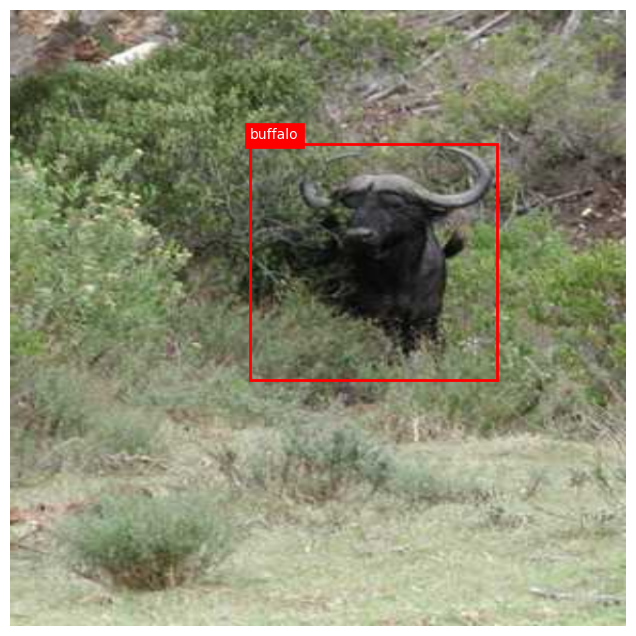

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# 1) Read the seed split list
with open("labeled.txt") as f:
    seed_list = [l.strip() for l in f if l.strip()]

# 2) Build the seed dataset & loader
seed_ds = ActiveLearningDataset(
    root_dir="/kaggle/input/awwwwwwwww/train",
    classes=CLASSES,
    transforms=get_valid_transform(),  # or get_train_transform() if you prefer
    img_size=RESIZE_TO,
    split="seed",
    split_dir="."                      # where labeled.txt lives
)
seed_loader = DataLoader(
    seed_ds,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

# 3) Grab the first sample
images, targets = next(iter(seed_loader))
img_t  = images[0]      # Tensor[3,H,W]
target = targets[0]

# 4) Convert to H×W×3 numpy in [0..1]
img = img_t.cpu().permute(1, 2, 0).numpy()
img = np.clip(img, 0.0, 1.0)

# 5) Plot with boxes
plt.figure(figsize=(8,8))
plt.imshow(img)
boxes  = target["boxes"].cpu().numpy().astype(int)
labels = target["labels"].cpu().numpy()
ax = plt.gca()

for box, lbl in zip(boxes, labels):
    x1, y1, x2, y2 = box
    rect = plt.Rectangle(
        (x1, y1), x2-x1, y2-y1,
        fill=False, edgecolor="r", linewidth=2
    )
    ax.add_patch(rect)
    ax.text(
        x1, y1-5, CLASSES[lbl],
        color="white", backgroundcolor="red", fontsize=10
    )

ax.axis("off")
plt.show()


In [10]:
import torch
import torch.optim as optim
from torchmetrics.detection.mean_ap import MeanAveragePrecision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate the architecture
model = create_model(num_classes=NUM_CLASSES)
# model.load_state_dict(torch.load("/kaggle/input/baseline-retinanet50/pytorch/default/1/kaggle/working/checkpoints/retinanet_epoch1_map0.727.pth", map_location=device))
model.to(device)
model.eval()

# define optimizer & (optional) scheduler
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# metric
metric = MeanAveragePrecision(box_format='xywh')


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth
100%|██████████| 146M/146M [00:00<00:00, 190MB/s]


In [11]:
NUM_CYCLES = 5
EPOCHS_PER_CYCLE = 1

In [12]:
import torch
import torch.optim as optim
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.utils.data import DataLoader, Dataset
import os
import cv2
import glob
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
import torchvision
from functools import partial
import random

# --- Configuration & Constants ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAIN_DIR = "/kaggle/input/awwwwwwwww/train"
VALID_DIR = "/kaggle/input/awwwwwwwww/valid"
CLASSES = ["__background__", "buffalo", "elephant", "rhino", "zebra"]
NUM_CLASSES = len(CLASSES)
RESIZE_TO = 640
BATCH_SIZE = 4
NUM_WORKERS = 2

# Active Learning Cycle Parameters
NUM_CYCLES = 10
EPOCHS_PER_CYCLE = 15
ACQUISITION_K = 50 # Number of new images to label per cycle

# Split file paths
LABELED_FILE   = "/kaggle/working/labeled.txt"
UNLABELED_FILE = "/kaggle/working/unlabeled.txt"

# --- Helper Functions & Dataset Class ---
def get_train_transform():
    """Defines the transformations for the training dataset."""
    return A.Compose([
        A.Resize(RESIZE_TO, RESIZE_TO),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_valid_transform():
    """Defines the transformations for validation and pool datasets."""
    return A.Compose([
        A.Resize(RESIZE_TO, RESIZE_TO),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    
def collate_fn(batch):
    """Standard collate function to handle batches of images and targets."""
    return tuple(zip(*batch))

def read_list(path):
    """Reads a list of filenames from a text file."""
    with open(path) as f:
        return [l.strip() for l in f if l.strip()]

def create_model(num_classes):
    """Creates a RetinaNet model with a custom classification head."""
    model = torchvision.models.detection.retinanet_resnet50_fpn_v2(weights=torchvision.models.detection.RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1)
    num_anchors = model.head.classification_head.num_anchors
    model.head.classification_head = torchvision.models.detection.retinanet.RetinaNetClassificationHead(
        in_channels=256,
        num_anchors=num_anchors,
        num_classes=num_classes,
        norm_layer=partial(torch.nn.GroupNorm, 32)
    )
    return model

class ActiveLearningDataset(Dataset):
    """Dataset class for active learning cycles."""
    def __init__(self, root_dir, transforms=None, split="all", split_dir="/kaggle/working/"):
        self.image_dir = os.path.join(root_dir, "images")
        self.label_dir = os.path.join(root_dir, "labels")
        self.transforms = transforms

        # Determine which split file to use
        if split == "seed":
            split_path = os.path.join(split_dir, "labeled.txt")
        elif split == "pool":
            split_path = os.path.join(split_dir, "unlabeled.txt")
        else:
            split_path = None

        # Filter image paths based on the split file
        valid_filenames = None
        if split_path and os.path.exists(split_path):
            with open(split_path) as f:
                valid_filenames = {l.strip() for l in f if l.strip()}
        
        all_image_paths = sorted(glob.glob(os.path.join(self.image_dir, "*.*")))
        if valid_filenames:
            self.image_paths = [p for p in all_image_paths if os.path.basename(p) in valid_filenames]
        else:
            self.image_paths = all_image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        img_h, img_w, _ = img.shape

        label_path = os.path.join(self.label_dir, os.path.splitext(os.path.basename(image_path))[0] + ".txt")
        
        boxes, labels = [], []
        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    c, cx, cy, w, h = map(float, line.split())
                    labels.append(int(c) + 1)
                    x_min = max(0.0, (cx - w / 2) * img_w)
                    y_min = max(0.0, (cy - h / 2) * img_h)
                    x_max = min(img_w, (cx + w / 2) * img_w)
                    y_max = min(img_h, (cy + h / 2) * img_h)
                    boxes.append([x_min, y_min, x_max, y_max])

        target = {}
        if self.transforms:
            transformed = self.transforms(image=img, bboxes=boxes, labels=labels)
            img = transformed['image']
            boxes = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
            labels = torch.as_tensor(transformed['labels'], dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        
        if boxes.shape[0] > 0:
            target["area"] = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
            target["iscrowd"] = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        else:
            target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
            target["area"] = torch.tensor([], dtype=torch.float32)
            target["iscrowd"] = torch.tensor([], dtype=torch.int64)

        return img, target

# --- Model Initialization ---
model = create_model(num_classes=NUM_CLASSES)
model.to(DEVICE)
metric = MeanAveragePrecision(box_format='xyxy')

# --- Main Active Learning Loop ---
for cycle in range(1, NUM_CYCLES + 1):
    # Load current splits from text files
    labeled_list = read_list(LABELED_FILE)
    unlabeled_list = read_list(UNLABELED_FILE)
    print(f"\n{'='*20} Cycle {cycle} of {NUM_CYCLES} {'='*20}")
    print(f" Labeled: {len(labeled_list)} images | Unlabeled: {len(unlabeled_list)} images")

    optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # 1. Create Datasets and DataLoaders for the current cycle
    seed_ds = ActiveLearningDataset(TRAIN_DIR, transforms=get_train_transform(), split="seed", split_dir="/kaggle/working/")
    seed_loader = DataLoader(seed_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=NUM_WORKERS)
    
    valid_ds = ActiveLearningDataset(VALID_DIR, transforms=get_valid_transform(), split="all")
    valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=NUM_WORKERS)

    # 2. Train on the current labeled seed set
    model.train()
    for ep in range(1, EPOCHS_PER_CYCLE + 1):
        progress_bar = tqdm(seed_loader, desc=f"Epoch {ep}/{EPOCHS_PER_CYCLE}")
        running_loss = 0.0
        for imgs, targets in progress_bar:
            imgs = [img.to(DEVICE) for img in imgs]
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            
            loss_dict = model(imgs, targets)
            loss = sum(l for l in loss_dict.values())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        if lr_scheduler: lr_scheduler.step()
        print(f"  Epoch {ep} Average Loss: {running_loss / len(seed_loader):.4f}")

    # 3. Evaluate the model on the validation set
    metric.reset()
    model.eval()
    with torch.no_grad():
        for imgs, targets in tqdm(valid_loader, desc="Evaluating"):
            imgs = [img.to(DEVICE) for img in imgs]
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            outputs = model(imgs)
            metric.update(outputs, targets)
            
    val_map = metric.compute()['map'].item()
    print(f" Validation mAP: {val_map:.4f}")

    # 4. ACQUISITION STEP: PURE RANDOM SAMPLING
    # The original uncertainty scoring logic has been removed.
    # We now select K new images randomly from the unlabeled pool.
    print(f"\n Acquiring {ACQUISITION_K} new images for the next cycle via random sampling.")
    
    # Determine how many images to sample
    num_to_acquire = min(ACQUISITION_K, len(unlabeled_list))
    
    if num_to_acquire > 0:
        # Directly sample K images randomly from the unlabeled list
        to_add = random.sample(unlabeled_list, num_to_acquire)
    else:
        # Stop if there are no more images to label
        print("No more unlabeled images to acquire. Ending loop.")
        break
        
    # 5. Update the split files for the next cycle
    new_labeled_list = labeled_list + to_add
    new_unlabeled_list = [fn for fn in unlabeled_list if fn not in to_add]
    with open(LABELED_FILE, "w") as f: f.write("\n".join(new_labeled_list))
    with open(UNLABELED_FILE, "w") as f: f.write("\n".join(new_unlabeled_list))

print("\n Active learning loop completed.")



==================== Cycle 1 of 10 ====================
 Labeled: 105 images | Unlabeled: 947 images


Epoch 1/15:   0%|          | 0/27 [00:00<?, ?it/s]

  Epoch 1 Average Loss: 0.9466


Epoch 2/15:   0%|          | 0/27 [00:00<?, ?it/s]

  Epoch 2 Average Loss: 0.6343


Epoch 3/15:   0%|          | 0/27 [00:00<?, ?it/s]

  Epoch 3 Average Loss: 0.4913


Epoch 4/15:   0%|          | 0/27 [00:00<?, ?it/s]

  Epoch 4 Average Loss: 0.3819


Epoch 5/15:   0%|          | 0/27 [00:00<?, ?it/s]

  Epoch 5 Average Loss: 0.3473


Epoch 6/15:   0%|          | 0/27 [00:00<?, ?it/s]

  Epoch 6 Average Loss: 0.3360


Epoch 7/15:   0%|          | 0/27 [00:00<?, ?it/s]

  Epoch 7 Average Loss: 0.3272


Epoch 8/15:   0%|          | 0/27 [00:00<?, ?it/s]

  Epoch 8 Average Loss: 0.3243


Epoch 9/15:   0%|          | 0/27 [00:00<?, ?it/s]

  Epoch 9 Average Loss: 0.3214


Epoch 10/15:   0%|          | 0/27 [00:00<?, ?it/s]

  Epoch 10 Average Loss: 0.3246


Epoch 11/15:   0%|          | 0/27 [00:00<?, ?it/s]

  Epoch 11 Average Loss: 0.3319


Epoch 12/15:   0%|          | 0/27 [00:00<?, ?it/s]

  Epoch 12 Average Loss: 0.3233


Epoch 13/15:   0%|          | 0/27 [00:00<?, ?it/s]

  Epoch 13 Average Loss: 0.3272


Epoch 14/15:   0%|          | 0/27 [00:00<?, ?it/s]

  Epoch 14 Average Loss: 0.3223


Epoch 15/15:   0%|          | 0/27 [00:00<?, ?it/s]

  Epoch 15 Average Loss: 0.3306


Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


 Validation mAP: 0.4368

 Acquiring 50 new images for the next cycle via random sampling.

==================== Cycle 2 of 10 ====================
 Labeled: 155 images | Unlabeled: 897 images


Epoch 1/15:   0%|          | 0/39 [00:00<?, ?it/s]

  Epoch 1 Average Loss: 0.4137


Epoch 2/15:   0%|          | 0/39 [00:00<?, ?it/s]

  Epoch 2 Average Loss: 0.3702


Epoch 3/15:   0%|          | 0/39 [00:00<?, ?it/s]

  Epoch 3 Average Loss: 0.3396


Epoch 4/15:   0%|          | 0/39 [00:00<?, ?it/s]

  Epoch 4 Average Loss: 0.2771


Epoch 5/15:   0%|          | 0/39 [00:00<?, ?it/s]

  Epoch 5 Average Loss: 0.2374


Epoch 6/15:   0%|          | 0/39 [00:00<?, ?it/s]

  Epoch 6 Average Loss: 0.2319


Epoch 7/15:   0%|          | 0/39 [00:00<?, ?it/s]

  Epoch 7 Average Loss: 0.2190


Epoch 8/15:   0%|          | 0/39 [00:00<?, ?it/s]

  Epoch 8 Average Loss: 0.2187


Epoch 9/15:   0%|          | 0/39 [00:00<?, ?it/s]

  Epoch 9 Average Loss: 0.2230


Epoch 10/15:   0%|          | 0/39 [00:00<?, ?it/s]

  Epoch 10 Average Loss: 0.2213


Epoch 11/15:   0%|          | 0/39 [00:00<?, ?it/s]

  Epoch 11 Average Loss: 0.2207


Epoch 12/15:   0%|          | 0/39 [00:00<?, ?it/s]

  Epoch 12 Average Loss: 0.2219


Epoch 13/15:   0%|          | 0/39 [00:00<?, ?it/s]

  Epoch 13 Average Loss: 0.2235


Epoch 14/15:   0%|          | 0/39 [00:00<?, ?it/s]

  Epoch 14 Average Loss: 0.2142


Epoch 15/15:   0%|          | 0/39 [00:00<?, ?it/s]

  Epoch 15 Average Loss: 0.2221


Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

 Validation mAP: 0.6066

 Acquiring 50 new images for the next cycle via random sampling.

==================== Cycle 3 of 10 ====================
 Labeled: 205 images | Unlabeled: 847 images


Epoch 1/15:   0%|          | 0/52 [00:00<?, ?it/s]

  Epoch 1 Average Loss: 0.3055


Epoch 2/15:   0%|          | 0/52 [00:00<?, ?it/s]

  Epoch 2 Average Loss: 0.2865


Epoch 3/15:   0%|          | 0/52 [00:00<?, ?it/s]

  Epoch 3 Average Loss: 0.2707


Epoch 4/15:   0%|          | 0/52 [00:00<?, ?it/s]

  Epoch 4 Average Loss: 0.1900


Epoch 5/15:   0%|          | 0/52 [00:00<?, ?it/s]

  Epoch 5 Average Loss: 0.1746


Epoch 6/15:   0%|          | 0/52 [00:00<?, ?it/s]

  Epoch 6 Average Loss: 0.1718


Epoch 7/15:   0%|          | 0/52 [00:00<?, ?it/s]

  Epoch 7 Average Loss: 0.1586


Epoch 8/15:   0%|          | 0/52 [00:00<?, ?it/s]

  Epoch 8 Average Loss: 0.1589


Epoch 9/15:   0%|          | 0/52 [00:00<?, ?it/s]

  Epoch 9 Average Loss: 0.1599


Epoch 10/15:   0%|          | 0/52 [00:00<?, ?it/s]

  Epoch 10 Average Loss: 0.1595


Epoch 11/15:   0%|          | 0/52 [00:00<?, ?it/s]

  Epoch 11 Average Loss: 0.1597


Epoch 12/15:   0%|          | 0/52 [00:00<?, ?it/s]

  Epoch 12 Average Loss: 0.1569


Epoch 13/15:   0%|          | 0/52 [00:00<?, ?it/s]

  Epoch 13 Average Loss: 0.1619


Epoch 14/15:   0%|          | 0/52 [00:00<?, ?it/s]

  Epoch 14 Average Loss: 0.1602


Epoch 15/15:   0%|          | 0/52 [00:00<?, ?it/s]

  Epoch 15 Average Loss: 0.1590


Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

 Validation mAP: 0.7415

 Acquiring 50 new images for the next cycle via random sampling.

==================== Cycle 4 of 10 ====================
 Labeled: 255 images | Unlabeled: 797 images


Epoch 1/15:   0%|          | 0/64 [00:00<?, ?it/s]

  Epoch 1 Average Loss: 0.2010


Epoch 2/15:   0%|          | 0/64 [00:00<?, ?it/s]

  Epoch 2 Average Loss: 0.2072


Epoch 3/15:   0%|          | 0/64 [00:00<?, ?it/s]

  Epoch 3 Average Loss: 0.1677


Epoch 4/15:   0%|          | 0/64 [00:00<?, ?it/s]

  Epoch 4 Average Loss: 0.1299


Epoch 5/15:   0%|          | 0/64 [00:00<?, ?it/s]

  Epoch 5 Average Loss: 0.1201


Epoch 6/15:   0%|          | 0/64 [00:00<?, ?it/s]

  Epoch 6 Average Loss: 0.1106


Epoch 7/15:   0%|          | 0/64 [00:00<?, ?it/s]

  Epoch 7 Average Loss: 0.1111


Epoch 8/15:   0%|          | 0/64 [00:00<?, ?it/s]

  Epoch 8 Average Loss: 0.1093


Epoch 9/15:   0%|          | 0/64 [00:00<?, ?it/s]

  Epoch 9 Average Loss: 0.1082


Epoch 10/15:   0%|          | 0/64 [00:00<?, ?it/s]

  Epoch 10 Average Loss: 0.1040


Epoch 11/15:   0%|          | 0/64 [00:00<?, ?it/s]

  Epoch 11 Average Loss: 0.1102


Epoch 12/15:   0%|          | 0/64 [00:00<?, ?it/s]

  Epoch 12 Average Loss: 0.1046


Epoch 13/15:   0%|          | 0/64 [00:00<?, ?it/s]

  Epoch 13 Average Loss: 0.1067


Epoch 14/15:   0%|          | 0/64 [00:00<?, ?it/s]

  Epoch 14 Average Loss: 0.1097


Epoch 15/15:   0%|          | 0/64 [00:00<?, ?it/s]

  Epoch 15 Average Loss: 0.1089


Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

 Validation mAP: 0.7447

 Acquiring 50 new images for the next cycle via random sampling.

==================== Cycle 5 of 10 ====================
 Labeled: 305 images | Unlabeled: 747 images


Epoch 1/15:   0%|          | 0/77 [00:00<?, ?it/s]

  Epoch 1 Average Loss: 0.1764


Epoch 2/15:   0%|          | 0/77 [00:00<?, ?it/s]

  Epoch 2 Average Loss: 0.1742


Epoch 3/15:   0%|          | 0/77 [00:00<?, ?it/s]

  Epoch 3 Average Loss: 0.1531


Epoch 4/15:   0%|          | 0/77 [00:00<?, ?it/s]

  Epoch 4 Average Loss: 0.1210


Epoch 5/15:   0%|          | 0/77 [00:00<?, ?it/s]

  Epoch 5 Average Loss: 0.1054


Epoch 6/15:   0%|          | 0/77 [00:00<?, ?it/s]

  Epoch 6 Average Loss: 0.1044


Epoch 7/15:   0%|          | 0/77 [00:00<?, ?it/s]

  Epoch 7 Average Loss: 0.0915


Epoch 8/15:   0%|          | 0/77 [00:00<?, ?it/s]

  Epoch 8 Average Loss: 0.0973


Epoch 9/15:   0%|          | 0/77 [00:00<?, ?it/s]

  Epoch 9 Average Loss: 0.0965


Epoch 10/15:   0%|          | 0/77 [00:00<?, ?it/s]

  Epoch 10 Average Loss: 0.0928


Epoch 11/15:   0%|          | 0/77 [00:00<?, ?it/s]

  Epoch 11 Average Loss: 0.0944


Epoch 12/15:   0%|          | 0/77 [00:00<?, ?it/s]

  Epoch 12 Average Loss: 0.0939


Epoch 13/15:   0%|          | 0/77 [00:00<?, ?it/s]

  Epoch 13 Average Loss: 0.0932


Epoch 14/15:   0%|          | 0/77 [00:00<?, ?it/s]

  Epoch 14 Average Loss: 0.0923


Epoch 15/15:   0%|          | 0/77 [00:00<?, ?it/s]

  Epoch 15 Average Loss: 0.0939


Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

 Validation mAP: 0.7483

 Acquiring 50 new images for the next cycle via random sampling.

==================== Cycle 6 of 10 ====================
 Labeled: 355 images | Unlabeled: 697 images


Epoch 1/15:   0%|          | 0/89 [00:00<?, ?it/s]

  Epoch 1 Average Loss: 0.1498


Epoch 2/15:   0%|          | 0/89 [00:00<?, ?it/s]

  Epoch 2 Average Loss: 0.1271


Epoch 3/15:   0%|          | 0/89 [00:00<?, ?it/s]

  Epoch 3 Average Loss: 0.1537


Epoch 4/15:   0%|          | 0/89 [00:00<?, ?it/s]

  Epoch 4 Average Loss: 0.1032


Epoch 5/15:   0%|          | 0/89 [00:00<?, ?it/s]

  Epoch 5 Average Loss: 0.0973


Epoch 6/15:   0%|          | 0/89 [00:00<?, ?it/s]

  Epoch 6 Average Loss: 0.0943


Epoch 7/15:   0%|          | 0/89 [00:00<?, ?it/s]

  Epoch 7 Average Loss: 0.0897


Epoch 8/15:   0%|          | 0/89 [00:00<?, ?it/s]

  Epoch 8 Average Loss: 0.0882


Epoch 9/15:   0%|          | 0/89 [00:00<?, ?it/s]

  Epoch 9 Average Loss: 0.0895


Epoch 10/15:   0%|          | 0/89 [00:00<?, ?it/s]

  Epoch 10 Average Loss: 0.0880


Epoch 11/15:   0%|          | 0/89 [00:00<?, ?it/s]

  Epoch 11 Average Loss: 0.0885


Epoch 12/15:   0%|          | 0/89 [00:00<?, ?it/s]

  Epoch 12 Average Loss: 0.0882


Epoch 13/15:   0%|          | 0/89 [00:00<?, ?it/s]

  Epoch 13 Average Loss: 0.0897


Epoch 14/15:   0%|          | 0/89 [00:00<?, ?it/s]

  Epoch 14 Average Loss: 0.0930


Epoch 15/15:   0%|          | 0/89 [00:00<?, ?it/s]

  Epoch 15 Average Loss: 0.0873


Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

 Validation mAP: 0.7564

 Acquiring 50 new images for the next cycle via random sampling.

==================== Cycle 7 of 10 ====================
 Labeled: 405 images | Unlabeled: 647 images


Epoch 1/15:   0%|          | 0/102 [00:00<?, ?it/s]

  Epoch 1 Average Loss: 0.1434


Epoch 2/15:   0%|          | 0/102 [00:00<?, ?it/s]

  Epoch 2 Average Loss: 0.1420


Epoch 3/15:   0%|          | 0/102 [00:00<?, ?it/s]

  Epoch 3 Average Loss: 0.1326


Epoch 4/15:   0%|          | 0/102 [00:00<?, ?it/s]

  Epoch 4 Average Loss: 0.0938


Epoch 5/15:   0%|          | 0/102 [00:00<?, ?it/s]

  Epoch 5 Average Loss: 0.0852


Epoch 6/15:   0%|          | 0/102 [00:00<?, ?it/s]

  Epoch 6 Average Loss: 0.0854


Epoch 7/15:   0%|          | 0/102 [00:00<?, ?it/s]

  Epoch 7 Average Loss: 0.0816


Epoch 8/15:   0%|          | 0/102 [00:00<?, ?it/s]

  Epoch 8 Average Loss: 0.0840


Epoch 9/15:   0%|          | 0/102 [00:00<?, ?it/s]

  Epoch 9 Average Loss: 0.0831


Epoch 10/15:   0%|          | 0/102 [00:00<?, ?it/s]

  Epoch 10 Average Loss: 0.0838


Epoch 11/15:   0%|          | 0/102 [00:00<?, ?it/s]

  Epoch 11 Average Loss: 0.0814


Epoch 12/15:   0%|          | 0/102 [00:00<?, ?it/s]

  Epoch 12 Average Loss: 0.0840


Epoch 13/15:   0%|          | 0/102 [00:00<?, ?it/s]

  Epoch 13 Average Loss: 0.0824


Epoch 14/15:   0%|          | 0/102 [00:00<?, ?it/s]

  Epoch 14 Average Loss: 0.0816


Epoch 15/15:   0%|          | 0/102 [00:00<?, ?it/s]

  Epoch 15 Average Loss: 0.0813


Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

 Validation mAP: 0.7765

 Acquiring 50 new images for the next cycle via random sampling.

==================== Cycle 8 of 10 ====================
 Labeled: 455 images | Unlabeled: 597 images


Epoch 1/15:   0%|          | 0/114 [00:00<?, ?it/s]

  Epoch 1 Average Loss: 0.1298


Epoch 2/15:   0%|          | 0/114 [00:00<?, ?it/s]

  Epoch 2 Average Loss: 0.1178


Epoch 3/15:   0%|          | 0/114 [00:00<?, ?it/s]

  Epoch 3 Average Loss: 0.1364


Epoch 4/15:   0%|          | 0/114 [00:00<?, ?it/s]

  Epoch 4 Average Loss: 0.1060


Epoch 5/15:   0%|          | 0/114 [00:00<?, ?it/s]

  Epoch 5 Average Loss: 0.0940


Epoch 6/15:   0%|          | 0/114 [00:00<?, ?it/s]

  Epoch 6 Average Loss: 0.0893


Epoch 7/15:   0%|          | 0/114 [00:00<?, ?it/s]

  Epoch 7 Average Loss: 0.0875


Epoch 8/15:   0%|          | 0/114 [00:00<?, ?it/s]

  Epoch 8 Average Loss: 0.0839


Epoch 9/15:   0%|          | 0/114 [00:00<?, ?it/s]

  Epoch 9 Average Loss: 0.0878


Epoch 10/15:   0%|          | 0/114 [00:00<?, ?it/s]

  Epoch 10 Average Loss: 0.0858


Epoch 11/15:   0%|          | 0/114 [00:00<?, ?it/s]

  Epoch 11 Average Loss: 0.0847


Epoch 12/15:   0%|          | 0/114 [00:00<?, ?it/s]

  Epoch 12 Average Loss: 0.0849


Epoch 13/15:   0%|          | 0/114 [00:00<?, ?it/s]

  Epoch 13 Average Loss: 0.0861


Epoch 14/15:   0%|          | 0/114 [00:00<?, ?it/s]

  Epoch 14 Average Loss: 0.0849


Epoch 15/15:   0%|          | 0/114 [00:00<?, ?it/s]

  Epoch 15 Average Loss: 0.0860


Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

 Validation mAP: 0.7602

 Acquiring 50 new images for the next cycle via random sampling.

==================== Cycle 9 of 10 ====================
 Labeled: 505 images | Unlabeled: 547 images


Epoch 1/15:   0%|          | 0/127 [00:00<?, ?it/s]

  Epoch 1 Average Loss: 0.1282


Epoch 2/15:   0%|          | 0/127 [00:00<?, ?it/s]

  Epoch 2 Average Loss: 0.1077


Epoch 3/15:   0%|          | 0/127 [00:00<?, ?it/s]

  Epoch 3 Average Loss: 0.0957


Epoch 4/15:   0%|          | 0/127 [00:00<?, ?it/s]

  Epoch 4 Average Loss: 0.0787


Epoch 5/15:   0%|          | 0/127 [00:00<?, ?it/s]

  Epoch 5 Average Loss: 0.0726


Epoch 6/15:   0%|          | 0/127 [00:00<?, ?it/s]

  Epoch 6 Average Loss: 0.0716


Epoch 7/15:   0%|          | 0/127 [00:00<?, ?it/s]

  Epoch 7 Average Loss: 0.0720


Epoch 8/15:   0%|          | 0/127 [00:00<?, ?it/s]

  Epoch 8 Average Loss: 0.0713


Epoch 9/15:   0%|          | 0/127 [00:00<?, ?it/s]

  Epoch 9 Average Loss: 0.0699


Epoch 10/15:   0%|          | 0/127 [00:00<?, ?it/s]

  Epoch 10 Average Loss: 0.0699


Epoch 11/15:   0%|          | 0/127 [00:00<?, ?it/s]

  Epoch 11 Average Loss: 0.0693


Epoch 12/15:   0%|          | 0/127 [00:00<?, ?it/s]

  Epoch 12 Average Loss: 0.0698


Epoch 13/15:   0%|          | 0/127 [00:00<?, ?it/s]

  Epoch 13 Average Loss: 0.0710


Epoch 14/15:   0%|          | 0/127 [00:00<?, ?it/s]

  Epoch 14 Average Loss: 0.0707


Epoch 15/15:   0%|          | 0/127 [00:00<?, ?it/s]

  Epoch 15 Average Loss: 0.0706


Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

 Validation mAP: 0.7787

 Acquiring 50 new images for the next cycle via random sampling.

==================== Cycle 10 of 10 ====================
 Labeled: 555 images | Unlabeled: 497 images


Epoch 1/15:   0%|          | 0/139 [00:00<?, ?it/s]

  Epoch 1 Average Loss: 0.0915


Epoch 2/15:   0%|          | 0/139 [00:00<?, ?it/s]

  Epoch 2 Average Loss: 0.0903


Epoch 3/15:   0%|          | 0/139 [00:00<?, ?it/s]

  Epoch 3 Average Loss: 0.0815


Epoch 4/15:   0%|          | 0/139 [00:00<?, ?it/s]

  Epoch 4 Average Loss: 0.0686


Epoch 5/15:   0%|          | 0/139 [00:00<?, ?it/s]

  Epoch 5 Average Loss: 0.0658


Epoch 6/15:   0%|          | 0/139 [00:00<?, ?it/s]

  Epoch 6 Average Loss: 0.0641


Epoch 7/15:   0%|          | 0/139 [00:00<?, ?it/s]

  Epoch 7 Average Loss: 0.0620


Epoch 8/15:   0%|          | 0/139 [00:00<?, ?it/s]

  Epoch 8 Average Loss: 0.0627


Epoch 9/15:   0%|          | 0/139 [00:00<?, ?it/s]

  Epoch 9 Average Loss: 0.0627


Epoch 10/15:   0%|          | 0/139 [00:00<?, ?it/s]

  Epoch 10 Average Loss: 0.0620


Epoch 11/15:   0%|          | 0/139 [00:00<?, ?it/s]

  Epoch 11 Average Loss: 0.0623


Epoch 12/15:   0%|          | 0/139 [00:00<?, ?it/s]

  Epoch 12 Average Loss: 0.0609


Epoch 13/15:   0%|          | 0/139 [00:00<?, ?it/s]

  Epoch 13 Average Loss: 0.0634


Epoch 14/15:   0%|          | 0/139 [00:00<?, ?it/s]

  Epoch 14 Average Loss: 0.0634


Epoch 15/15:   0%|          | 0/139 [00:00<?, ?it/s]

  Epoch 15 Average Loss: 0.0619


Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

 Validation mAP: 0.7776

 Acquiring 50 new images for the next cycle via random sampling.

 Active learning loop completed.
